Cross-shelf transport (total) of 3DDIFF experiments
==

This notebook explores the similarities and differences between the 3 tracer transports along case 3DDIFF as well as canyon and no canyon cases. It looks at the transport normal to a shelf break wall<sup>1</sup>. Total Tracer Transport (TracTrans) is understood here as tracer transport (concentration * transport) per cell area; similarly, Total Transport (Trans) is transport per cell area, which is only the speed. This gives the following units:

$[TracTrans] = [C]ms^{-1} $

$[Trans] = [v] = ms^{-1} $

TracTrans = AdvFlux + DiffFlux / cell area

<sup>1</sup> Plane that goes from shelf-break depth to surface and all along the shelf break.

The base case to compare the effect of enhanced diffusivity is a run with GMREDI (because 3DDIFF exps use GMREDI too) but constant vertical diffusivity (CNTDIFF run03). The vertical diff for tracer 1 is $10^{-5}$ $m^2s^{-1}$ and $10^{-3}$ $m^2s^{-1}$ for tracer 2. An associated no-canyon case allows to isolate the effect of the canyon (CNTDIFF run07).  

3DDIFF runs include the following cases:

| Run   |   $k_{v_{in}}$ ($m^2s^{-1}$)   |  $k_{v_{out}}$ ($m^2s^{-1}$)  | Diffusivity file from  |
|:-----:|:------------------------------:|:-----------------------------:|:-----------------------|
|  01   | $10^{-3}$                      | $10^{-7}$                     |  old bathy             |
|  02   | $10^{-4}$                      | $10^{-7}$                     |  old bathy             |
|  03   | $10^{-3}$                      | $10^{-5}$                     |  old bathy             |
|  04   | $10^{-3}$                      | $10^{-7}$                     |  Quad bathy            |
|  05   | $10^{-4}$                      | $10^{-7}$                     |  Quad bathy            |
|  06   | $10^{-3}$                      | $10^{-5}$                     |  Quad bathy            |
|  07   | $10^{-4}$                      | $10^{-5}$                     |  Quad bathy            |


First three rund used an incorrectly built diffusivity. They are based on the old bathymetry (the one that produced little shock downstream) and we will see that it makes a difference. It is interesting that there is a difference between them since the incorrect file represents a different 'geography of mixing" than the uniform within-canyon enchancement of vertical diffusivity.

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

from math import *

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns

In [2]:
lib_path = os.path.abspath('/ocean/kramosmu/Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 

import ShelfBreakTools_MITgcm as sb

import savitzky_golay as sg

In [3]:
#Base case, iso =1 , No 3d diff.
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)
#for dimobj in CanyonGridOut.variables.values():
#    print dimobj
CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

FluxTR01 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/FluxTR01Glob.nc'
FluxOut1 = Dataset(FluxTR01)

FluxTR03 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/FluxTR03Glob.nc'
FluxOut3 = Dataset(FluxTR03)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonStateNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/stateGlob.nc'

FluxTR01NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/FluxTR01Glob.nc'
FluxTR03NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/FluxTR03Glob.nc'

In [4]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

z = CanyonStateOut.variables['Z']
#print(z[10])
Time = CanyonStateOut.variables['T']
#print(Time[:])

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells

yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

dxF = rout.getField(CanyonGrid, 'dxF')
drF = CanyonGridOut.variables['drF']

In [5]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [6]:
colors=['green','mediumseagreen','mediumaquamarine','springgreen',
        'olive','yellowgreen','lightseagreen','dodgerblue','lightskyblue']

In [7]:
VTRAC = rout.getField(FluxTR01,'VTRAC01') # 
UTRAC = rout.getField(FluxTR01,'UTRAC01') # 

VTRACNoC = rout.getField(FluxTR01NoC,'VTRAC01') # 
UTRACNoC = rout.getField(FluxTR01NoC,'UTRAC01') # 


In [8]:
zlev = 29
SBx, SBy = sb.findShelfBreak(zlev,hFacC)
SBxx = SBx[:-1]
SByy = SBy[:-1]
slope, theta = sb.findSlope(xc,yc,SBxx,SByy)
slopeFilt = sg.savitzky_golay(slope, 11, 3) # window size 11, polynomial order 3
thetaFilt = np.arctan(slopeFilt)

zlev = 29
SBxNoC, SByNoC = sb.findShelfBreak(zlev,hFacCNoC)
SBxxNoC = SBxNoC[:-1]
SByyNoC = SByNoC[:-1]
slopeNoC, thetaNoC = sb.findSlope(xc,yc,SBxxNoC,SByyNoC)
slopeFiltNoC = sg.savitzky_golay(slopeNoC, 11, 3) # window size 11, polynomial order 3
thetaFiltNoC = np.arctan(slopeFiltNoC)


In [9]:
# TRACER 1
FluxTR013d1 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run01/FluxTR01Glob.nc'
FluxOut13d1 = Dataset(FluxTR013d1)

FluxTR013d2 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run02/FluxTR01Glob.nc'
FluxOut13d2 = Dataset(FluxTR013d2)

FluxTR013d3 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run03/FluxTR01Glob.nc'
FluxOut13d3 = Dataset(FluxTR013d3)

#FluxTR013d4 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04/FluxTR01Glob.nc' rerun
#FluxOut13d4 = Dataset(FluxTR013d4)

#FluxTR013d5 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/FluxTR01Glob.nc' glueing
#FluxOut13d5 = Dataset(FluxTR013d5)

#FluxTR013d6 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06/FluxTR01Glob.nc' rerun
#FluxOut13d6 = Dataset(FluxTR013d6)

#FluxTR013d7 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run07/FluxTR01Glob.nc' rerun
#FluxOut13d7 = Dataset(FluxTR013d7)


In [10]:
VTRAC01 = rout.getField(FluxTR013d1,'VTRAC01') # 
UTRAC01 = rout.getField(FluxTR013d1,'UTRAC01') # 

VTRAC02 = rout.getField(FluxTR013d2,'VTRAC01') # 
UTRAC02 = rout.getField(FluxTR013d2,'UTRAC01') # 

VTRAC03 = rout.getField(FluxTR013d3,'VTRAC01') # 
UTRAC03 = rout.getField(FluxTR013d3,'UTRAC01') # 

#VTRAC04 = rout.getField(FluxTR04,'VTRAC01') # 
#UTRAC04 = rout.getField(FluxTR04,'UTRAC01') # 

#VTRAC05 = rout.getField(FluxTR05,'VTRAC01') # 
#UTRAC05 = rout.getField(FluxTR05,'UTRAC01') # 

#VTRAC06 = rout.getField(FluxTR06,'VTRAC01') # 
#UTRAC06 = rout.getField(FluxTR06,'UTRAC01') # 

#VTRAC07 = rout.getField(FluxTR07,'VTRAC01') # 
#TRAC07 = rout.getField(FluxTR07,'UTRAC01') # 


In [11]:

times = range(18)
ToTalTracTransBase=np.empty(18)
ToTalTracTransBaseNoC=np.empty(18)
ToTalTracTransRun01=np.empty(18)
ToTalTracTransRun02=np.empty(18)
ToTalTracTransRun03=np.empty(18)
ToTalTracTransRun04=np.empty(18)
ToTalTracTransRun05=np.empty(18)
ToTalTracTransRun06=np.empty(18)
ToTalTracTransRun07=np.empty(18)

for tt in times:
    VTRACPlot = sb.MerFluxSB(SBxx,SByy,tt,VTRAC,z,xc,zlev,hFacC,MaskC)
    UTRACPlot = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC,z,xc,zlev,hFacC,MaskC)
    
    VTRACPlot1 = sb.MerFluxSB(SBxx,SByy,tt,VTRAC01,z,xc,zlev,hFacC,MaskC)
    UTRACPlot1 = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC01,z,xc,zlev,hFacC,MaskC)
    
    VTRACPlot2 = sb.MerFluxSB(SBxx,SByy,tt,VTRAC02,z,xc,zlev,hFacC,MaskC)
    UTRACPlot2 = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC02,z,xc,zlev,hFacC,MaskC)
    
    VTRACPlot3 = sb.MerFluxSB(SBxx,SByy,tt,VTRAC03,z,xc,zlev,hFacC,MaskC)
    UTRACPlot3 = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC03,z,xc,zlev,hFacC,MaskC)
    
    #VTRACPlot4 = sb.MerFluxSB(SBxx,SByy,tt,VTRAC04,z,xc,zlev,hFacC,MaskC)
    #UTRACPlot4 = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC04,z,xc,zlev,hFacC,MaskC)
    
    #VTRACPlot5 = sb.MerFluxSB(SBxx,SByy,tt,VTRAC05,z,xc,zlev,hFacC,MaskC)
    #UTRACPlot5 = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC05,z,xc,zlev,hFacC,MaskC)
    
    #VTRACPlot6 = sb.MerFluxSB(SBxx,SByy,tt,VTRAC06,z,xc,zlev,hFacC,MaskC)
    #UTRACPlot6 = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC06,z,xc,zlev,hFacC,MaskC)
    
    #VTRACPlot7 = sb.MerFluxSB(SBxx,SByy,tt,VTRAC07,z,xc,zlev,hFacC,MaskC)
    #UTRACPlot7 = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC07,z,xc,zlev,hFacC,MaskC)
    
    VTRACPlotNoC = sb.MerFluxSB(SBxxNoC,SByyNoC,tt,VTRACNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    UTRACPlotNoC = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt,UTRACNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    
    
    TracTrans =  VTRACPlot[:,4:-5]*np.cos(thetaFilt) + UTRACPlot[:,4:-4]*np.sin(-thetaFilt) 
    TracTrans1 =  VTRACPlot1[:,4:-5]*np.cos(thetaFilt) + UTRACPlot1[:,4:-4]*np.sin(-thetaFilt) 
    TracTrans2 =  VTRACPlot2[:,4:-5]*np.cos(thetaFilt) + UTRACPlot2[:,4:-4]*np.sin(-thetaFilt) 
    TracTrans3 =  VTRACPlot3[:,4:-5]*np.cos(thetaFilt) + UTRACPlot3[:,4:-4]*np.sin(-thetaFilt) 
    #TracTrans4 =  VTRACPlot4[:,4:-5]*np.cos(thetaFilt) + UTRACPlot4[:,4:-4]*np.sin(-thetaFilt) 
    #TracTrans5 =  VTRACPlot5[:,4:-5]*np.cos(thetaFilt) + UTRACPlot5[:,4:-4]*np.sin(-thetaFilt) 
    #TracTrans6 =  VTRACPlot6[:,4:-5]*np.cos(thetaFilt) + UTRACPlot6[:,4:-4]*np.sin(-thetaFilt) 
    #TracTrans7 =  VTRACPlot7[:,4:-5]*np.cos(thetaFilt) + UTRACPlot7[:,4:-4]*np.sin(-thetaFilt) 
    TracTransNoC =  VTRACPlotNoC[:,4:-5]*np.cos(thetaFiltNoC) + UTRACPlotNoC[:,4:-4]*np.sin(-thetaFiltNoC) 
    
    ToTalTracTransBase[tt]= np.sum(TracTrans)
    ToTalTracTransRun01[tt]=np.sum(TracTrans1)
    ToTalTracTransRun02[tt]=np.sum(TracTrans2)
    ToTalTracTransRun03[tt]=np.sum(TracTrans3)
    #ToTalTracTransRun04=np.sum(TracTrans4)
    #ToTalTracTransRun05=np.sum(TracTrans5)
    #ToTalTracTransRun06=np.sum(TracTrans6)
    #ToTalTracTransRun07=np.sum(TracTrans7)
    ToTalTracTransBaseNoC[tt]=np.sum(TracTransNoC)
    
    
    

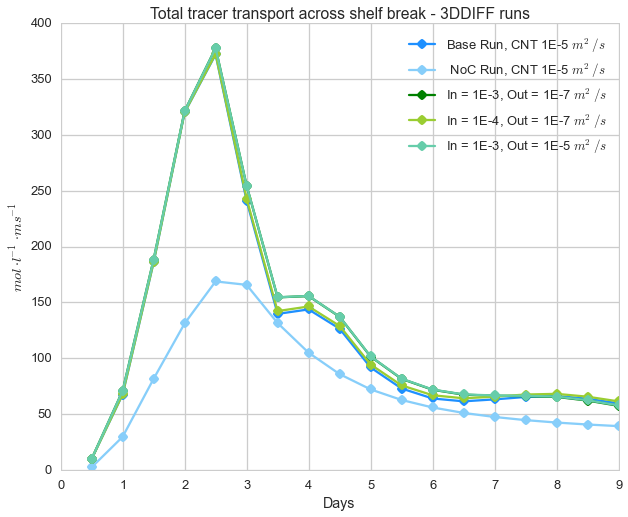

In [21]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'


fig44 = plt.figure(figsize=figSize)
plt.subplot(numRows,numCols,1)
ax = plt.gca()
ax.plot(times,ToTalTracTransBase[:],'o-',color=colors[7],label = 'Base Run, CNT 1E-5 $m^2/s$ ')
ax.plot(times,ToTalTracTransBaseNoC[:],'o-',color=colors[8],label = ' NoC Run, CNT 1E-5 $m^2/s$ ')
ax.plot(times,ToTalTracTransRun01[:],'o-',color=colors[0],label = 'In = 1E-3, Out = 1E-7 $m^2/s$')
ax.plot(times,ToTalTracTransRun02[:],'o-',color=colors[5],label = 'In = 1E-4, Out = 1E-7 $m^2/s$')
ax.plot(times,ToTalTracTransRun03[:],'o-',color=colors[2],label = 'In = 1E-3, Out = 1E-5 $m^2/s$')
#ax.plot(times,ToTalTracTransRun014[:],'o-',color=colors[4],label = 'Quad, In = 1E-3, Out = 1E-7 $m^2/s$')
#ax.plot(times,ToTalTracTransRun015[:],'o-',color=colors[5],label = 'Quad, In = 1E-4, Out = 1E-7 $m^2/s$')
#ax.plot(times,ToTalTracTransRun016[:],'o-',color=colors[6],label = 'Quad, In = 1E-3, Out = 1E-5 $m^2/s$')
#ax.plot(times,ToTalTracTransRun017[:],'o-',color=colors[7],label = 'Quad, In = 1E-4, Out = 1E-5 $m^2/s$')
    
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
plt.xlabel('Days')
plt.ylabel(unitsTr)
plt.title('Total tracer transport across shelf break - 3DDIFF runs')
    

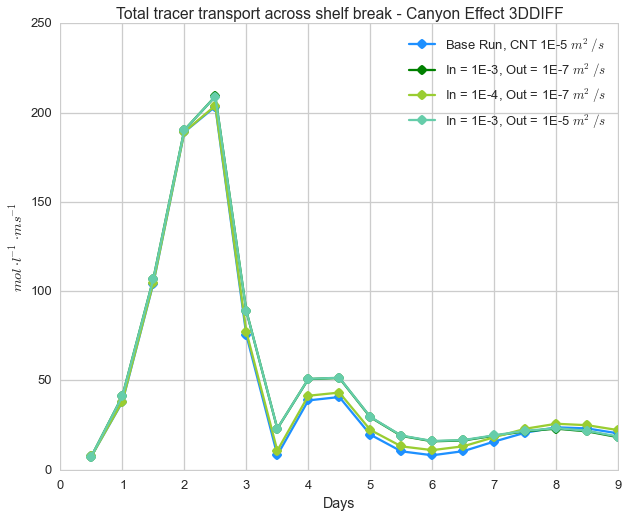

In [22]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'


fig44 = plt.figure(figsize=figSize)
plt.subplot(numRows,numCols,1)
ax = plt.gca()
ax.plot(times,ToTalTracTransBase[:]-ToTalTracTransBaseNoC[:],'o-',color=colors[7],label = 'Base Run, CNT 1E-5 $m^2/s$ ')
ax.plot(times,ToTalTracTransRun01[:]-ToTalTracTransBaseNoC[:],'o-',color=colors[0],label = 'In = 1E-3, Out = 1E-7 $m^2/s$')
ax.plot(times,ToTalTracTransRun02[:]-ToTalTracTransBaseNoC[:],'o-',color=colors[5],label = 'In = 1E-4, Out = 1E-7 $m^2/s$')
ax.plot(times,ToTalTracTransRun03[:]-ToTalTracTransBaseNoC[:],'o-',color=colors[2],label = 'In = 1E-3, Out = 1E-5 $m^2/s$')
    
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
plt.xlabel('Days')
plt.ylabel(unitsTr)
plt.title('Total tracer transport across shelf break - Canyon Effect 3DDIFF')
    

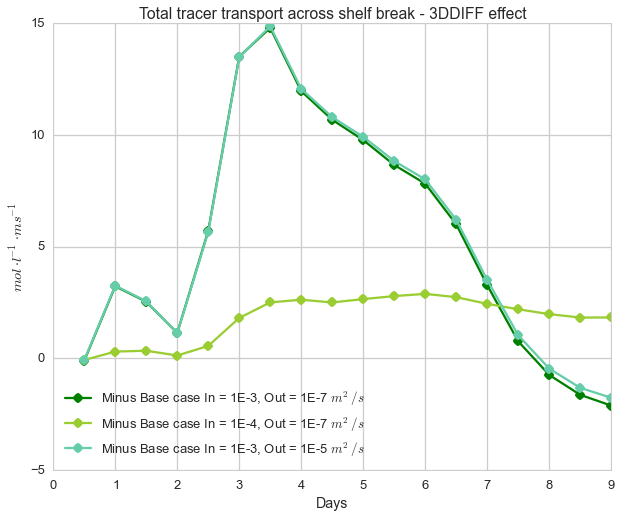

In [23]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'


fig44 = plt.figure(figsize=figSize)
plt.subplot(numRows,numCols,1)
ax = plt.gca()

ax.plot(times,ToTalTracTransRun01[:]-ToTalTracTransBase[:],'o-',color=colors[0],label = 'Minus Base case In = 1E-3, Out = 1E-7 $m^2/s$')
ax.plot(times,ToTalTracTransRun02[:]-ToTalTracTransBase[:],'o-',color=colors[5],label = 'Minus Base case In = 1E-4, Out = 1E-7 $m^2/s$')
ax.plot(times,ToTalTracTransRun03[:]-ToTalTracTransBase[:],'o-',color=colors[2],label = 'Minus Base case In = 1E-3, Out = 1E-5 $m^2/s$')
    
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
plt.xlabel('Days')
plt.ylabel(unitsTr)
plt.title('Total tracer transport across shelf break - 3DDIFF effect')
   